This will be a notebook for investigating the \[\[7,1,3\]\] color code. This is a 2D color code. I will be using the paper from quantinuum for references to quantum circuits. \
We can first start by preparing the logical qubit basis state. This circuit will prepare the logical basis state $\ket{0}_L$ which corresponds to the state/code word: 
$$ \ket{0}_L = \frac{1}{\sqrt{8}}\left( \ket{0000000} + \ket{1010101} + \ket{0110011} + \ket{1100110} + \ket{0001111} + \ket{1011010} + \ket{0111100} + \ket{1101001} \right)$$

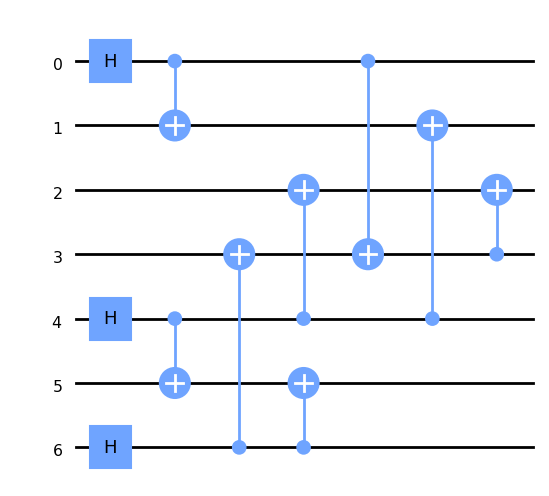

In [52]:
#encoding circuit to create the logical basis states
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

qreg_q = QuantumRegister(7, '')

encodingcircuit = QuantumCircuit(qreg_q)

encodingcircuit.h(qreg_q[0])
encodingcircuit.h(qreg_q[4])
encodingcircuit.h(qreg_q[6])
encodingcircuit.cx(qreg_q[0], qreg_q[1])
encodingcircuit.cx(qreg_q[4], qreg_q[5])
encodingcircuit.cx(qreg_q[6], qreg_q[3])
encodingcircuit.cx(qreg_q[4], qreg_q[2])
encodingcircuit.cx(qreg_q[6], qreg_q[5])
encodingcircuit.cx(qreg_q[0], qreg_q[3])
encodingcircuit.cx(qreg_q[4], qreg_q[1])
encodingcircuit.cx(qreg_q[3], qreg_q[2])
encodingcircuit.draw('mpl')
#@columns [0,0,0,1,1,2,3,3,4,5,6]

This circuit was taken from the paper from Quantinuum. Note that the 8th qubit and CNOTS going to it are for measuring the encoded state. \
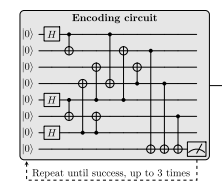 \
We can now measure the encoded state using the rest of the circuit given to see what values result. However we first want to create a general gate that represents the encoding circuit so we can append other quantum circuits to it: 

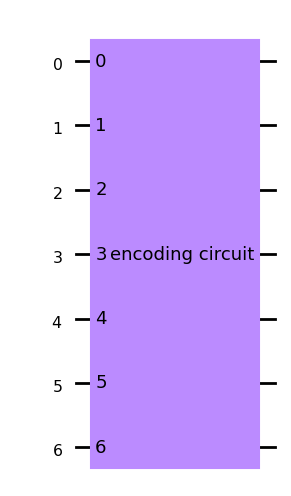

In [53]:
from qiskit.circuit import Gate

encodeGate= encodingcircuit.to_instruction(label='encoding circuit')

testcircuit= QuantumCircuit(qreg_q)
testcircuit.append(encodeGate, qreg_q) #add the encoding circuit to the new circuit
testcircuit.draw('mpl')

Lets test this circuit to make sure it outputs the desired statevector/code word:

In [62]:
from qiskit.opflow.state_fns import state_fn, dict_state_fn
from qiskit.opflow.operator_globals import X, Y, Z, I, CX, T, H, S, One, Zero
from qiskit.opflow.primitive_ops import PrimitiveOp
import numpy as np
from scipy import sparse
#encode_stateFn = state_fn.StateFn(encodingcircuit) #convert to state function 
encodeOp = PrimitiveOp(encodingcircuit)
statevec = (encodeOp @ Zero).eval()
print("1 / sqrt(8) = {}".format(np.round(1 / np.sqrt(8), 7)))
sp = statevec.to_spmatrix()
indices = sparse.find(sp)[1]
values = np.abs(sparse.find(sp)[2])
print(indices)
print(values)

bin_indices = []
#quick script to convert the indices to their binary representation:
for i in indices: 
    bin_indices = np.append(bin_indices, bin(i)) 
    print(np.binary_repr(i,7))
    print(np.binary_repr(i))
print(bin_indices)



1 / sqrt(8) = 0.3535534
[  0  15  54  57  85  90  99 108]
[0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]
0000000
0
0001111
1111
0110110
110110
0111001
111001
1010101
1010101
1011010
1011010
1100011
1100011
1101100
1101100
['0b0' '0b1111' '0b110110' '0b111001' '0b1010101' '0b1011010' '0b1100011'
 '0b1101100']


C:\Users\DLG\AppData\Local\Temp\ipykernel_27472\1176122918.py:7: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.circuit_op.CircuitOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  encodeOp = PrimitiveOp(encodingcircuit)


Curiously, it seems that some of the resultant states don't match up with the ones composing the logical $\ket{0_L}$. A good sanity check for something like this is to check if it is an eigenvector of the stabilizers. 
 

Now we can measure the encoding circuit using the 3 CNOTs. This constitutes a measurement in the logical Z basis.

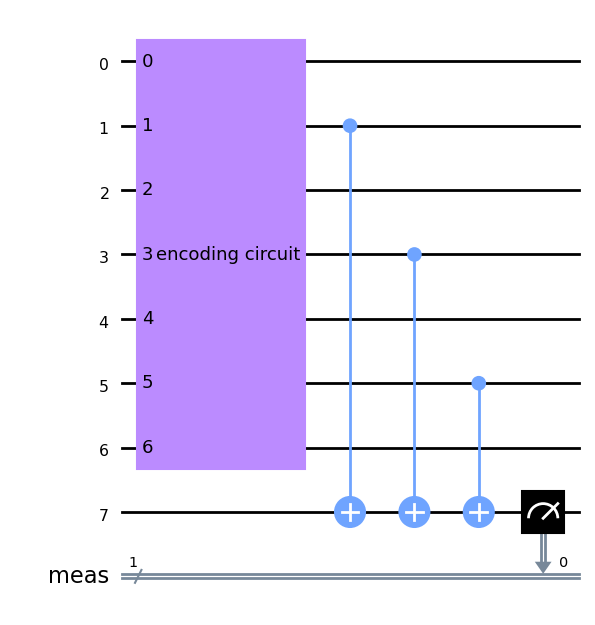

In [50]:
qreg_m = QuantumRegister(8, '')
creg_m = ClassicalRegister(1, name='meas')
meascircuit = QuantumCircuit(qreg_m, creg_m)
meascircuit.append(encodeGate, qreg_m[:7])
meascircuit.cx(control_qubit=qreg_m[1], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[3], target_qubit=qreg_m[7])
meascircuit.cx(control_qubit=qreg_m[5], target_qubit=qreg_m[7])
meascircuit.measure(7, 0)
meascircuit.draw('mpl')